# Imports and file handling

- feature engineeering
- finne viktige features og korrelert seg i mellom
- kombinere forskjellige ting
- ikkje ta bort noe
- vent med modell og hyperparameter
- ulike modeller
- bare trene på mai og juni 
- validere på estimert data
- AutoGluon
- Bedre miks av estimated vs observed
- Trene en modell per site
- Droppe fylle inn NaN verdier


Forslag til features
- Is_estimated
- season
- week
- direct rad * sin(sun_azimuth)

## Import files and set matplotlib params. Only change if you want new python packages

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import catboost as cb
import lightgbm as lgb
from tabulate import tabulate

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold 

import re
from copy import deepcopy


import seaborn as sns

import pickle

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

import datetime

import optuna

newparams = {'figure.figsize': (12, 8), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}

plt.rcParams.update(newparams)

## File handling

This part retrieves the from the provided file structure into one dataframe. This is made in order to be able to easily iterate through the dataframes later during feature engineering and merging in order to not have to do the same lines for each file and each site (3 times 3 = 9 times)

In [2]:
# data_path="../data/"
data_path=lambda f : f"../data/{f}/"

folders = ["A", "B", "C"]


dataframes = {f : {} for f in folders}
for folder in folders:
    for file in os.listdir(data_path(folder)):
        filename=file.split(".")[0]
        dataframes[folder][filename]=pd.read_parquet(data_path(folder)+ file)


# Pre processing

## Helpful functions

site_to_num functions in order to easily convert from site names to associated numbers. During the process the numbers have gone from 0, 1, 2 to 1, 2, 3, there may be some artefacts from the old system in the code. It is most safe to use site_to_num whenever this function is used.

merge_frames is a function made to convert the dataframes dictionary into a df containing all the relevant dataframes for training. The X frame used for submission is excluded. 

In [3]:
def site_to_num(site):
    if site not in ["A", "B", "C"]:
        raise Exception("site must be A, B or C")
    elif site=="A":
        return 1
    elif site=="B":
        return 2
    elif site=="C":
        return 3


def feature(train, train_weather):
    train["time1"] = train["time"] + pd.offsets.DateOffset(minutes=15)
    train["time2"] = train["time"] + pd.offsets.DateOffset(minutes=30)
    train["time3"] = train["time"] + pd.offsets.DateOffset(minutes=45)

    train_weather_0 = train_weather[train_weather["date_forecast"].isin(train["time"])].reset_index()
    train_weather_0 = train_weather_0.drop(columns=['index', 'date_forecast'])

    train_weather_1 = train_weather[train_weather['date_forecast'].isin(train['time1'])].reset_index()
    train_weather_1.columns = [key+'1' for key in train_weather_1.columns]
    train_weather_1 = train_weather_1.drop(columns=['index1', 'date_forecast1'])

    train_weather_2 = train_weather[train_weather['date_forecast'].isin(train['time2'])].reset_index()
    train_weather_2.columns = [key+'2' for key in train_weather_2.columns]
    train_weather_2 = train_weather_2.drop(columns=['index2', 'date_forecast2'])

    train_weather_3 = train_weather[train_weather['date_forecast'].isin(train['time3'])].reset_index()
    train_weather_3.columns = [key+'3' for key in train_weather_3.columns]
    train_weather_3 = train_weather_3.drop(columns=['index3', 'date_forecast3'])

    # print(train.shape, train_weather_0.shape, train_weather_1.shape, train_weather_2.shape, train_weather_3.shape)
    feature_1 = pd.concat([train, train_weather_0, train_weather_1, train_weather_2, train_weather_3], axis=1)
    feature_1 = feature_1[feature_1['time'].isin(train['time'])]
    if "date_calc" in feature_1.columns:
        feature_1 = feature_1.drop(columns=["date_calc1", "date_calc2", "date_calc3"])
    
    if "site" in feature_1.columns:
        feature_1 = feature_1.drop(columns=["site1", "site2", "site3"])



    

    return feature_1
# .drop(columns=[f"time{i}"  for i in range(1, 4)])


def merge_frames(dataframes):
    to_concat=[]

    for site in dataframes.keys():

        # for column in ["X_train_observed", "X_train_estimated"]:
        #     df_to_add=pd.merge(left=dataframes[site]["train_targets"], right=dataframes[site][column], left_on="time", right_on="date_forecast")
        #     df_to_add["site"]=site_to_num(site)
        #     to_concat.append(df_to_add.copy())
        for column in ["X_train_observed", "X_train_estimated"]:
            df_Y = dataframes[site]["train_targets"]
            df_Y = df_Y[df_Y["time"].isin(dataframes[site][column]["date_forecast"])].reset_index()
            df_to_add = feature(df_Y, dataframes[site][column])
            to_concat.append(df_to_add.copy())
            
            
    df = pd.concat(to_concat, ignore_index=True)
    
    return df.dropna(subset=["pv_measurement"])

In [4]:
# df_Y = dataframes["A"]["train_targets"]
# df_Y = df_Y[df_Y["time"].isin(dataframes["A"]["X_train_estimated"]["date_forecast"])].reset_index()
# df_test = feature(df_Y, dataframes["A"]["X_train_estimated"])

# df_test

## Find useful column types

X_frames and Y_frames are all the X frames and all the Y frames in their own lists. It is made in order to easily iterate through all X_frames or Y_frames. 

In [4]:
X_frames=[]
Y_frames=[]

for site in dataframes.keys():
    for frame in dataframes[site].keys():
        if "X" in frame:
            to_append=dataframes[site][frame]
            to_append["site"] = site_to_num(site)
            X_frames.append(to_append)
        else:
            to_append=dataframes[site][frame].copy()
            to_append["site"] = site_to_num(site)
            Y_frames.append(to_append)

Rolling cols and non_rolling cols are distinct subsets of columns.

Rolling columns are columns with floating point values where the variance in a single site is greater than 0. 

Non rolling columns are columns where the variance in a single site is 0. 

Later, categorical columns will also be added. These are columns which have categorical values accross sites.

In [5]:
rolling_cols= []
non_rolling_cols = []

for col in X_frames[0].columns:
    var = X_frames[0][col].std()
    if col in ["date_forecast", "date_calc"]:
        continue
    if var > 0:
        rolling_cols.append(col)
    else:
        non_rolling_cols.append(col)

print(non_rolling_cols)

['elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'wind_speed_w_1000hPa:ms', 'site']


## Merging frames

Here, we merge the frames in dataframes into a single frame, df.

In [6]:
df = merge_frames(dataframes)
df

index                time  ...  wind_speed_w_1000hPa:ms3           date_calc
0          0 2019-06-02 22:00:00  ...                      -0.0                 NaT
1          1 2019-06-02 23:00:00  ...                      -0.0                 NaT
2          2 2019-06-03 00:00:00  ...                      -0.0                 NaT
3          3 2019-06-03 01:00:00  ...                      -0.0                 NaT
4          4 2019-06-03 02:00:00  ...                      -0.0                 NaT
...      ...                 ...  ...                       ...                 ...
99009  32150 2023-04-30 19:00:00  ...                      -0.0 2023-04-29 07:00:05
99010  32151 2023-04-30 20:00:00  ...                      -0.0 2023-04-29 07:00:05
99011  32152 2023-04-30 21:00:00  ...                      -0.0 2023-04-29 07:00:05
99012  32153 2023-04-30 22:00:00  ...                      -0.0 2023-04-29 07:00:05
99013  32154 2023-04-30 23:00:00  ...                      -0.0 2023-04-29 07:00:05

[92951 rows x 188 columns]

# Remove outliers from B

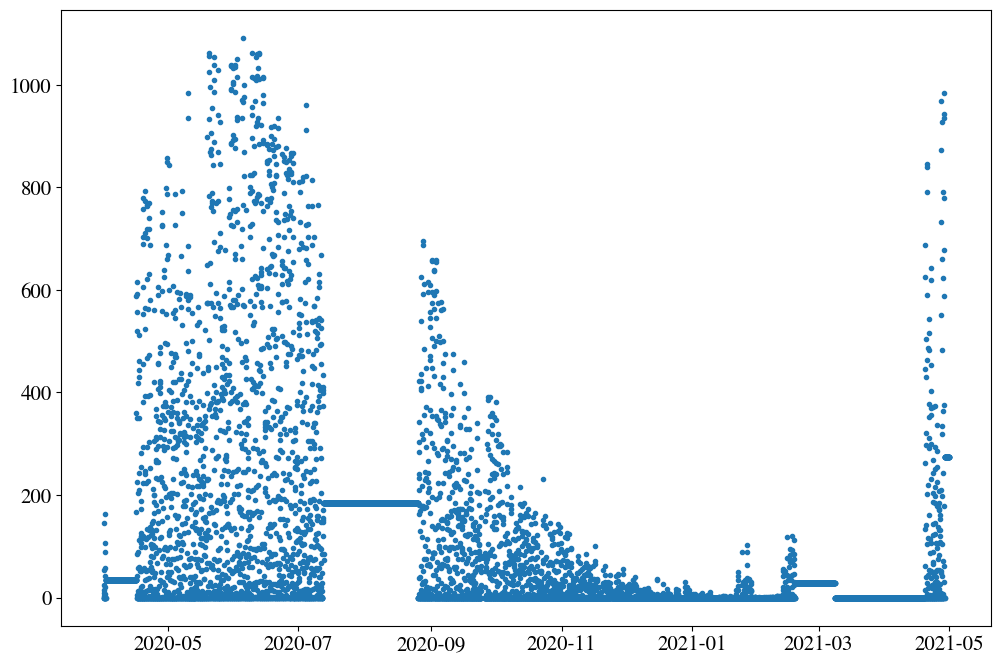

In [7]:
Y_col="pv_measurement"

df_B=df[df["site"]==site_to_num("B")]

filter_all=(df_B["time"] > "2020-4-1")& (df_B["time"] < "2021-5-1")
filter_1=(df_B["time"] > "2021-3-1")& (df_B["time"] < "2021-4-20")

df_B=df_B[filter_all]
plt.plot(df_B["time"], df_B[Y_col], ".")

In [8]:
mask_B = df["site"]==site_to_num("B")
mask = (df[Y_col] == df[Y_col].shift(1)) & df[Y_col]!=0

mask2 = ((df["time"] > "2021-3-1") & (df["time"] < "2021-4-20")) 
print(len(df))
df=df[~(mask & mask_B)]
df=df[~(mask2 & mask_B)]
print(len(df))

92951
88684


/tmp/ipykernel_20070/4221103035.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df[~(mask2 & mask_B)]


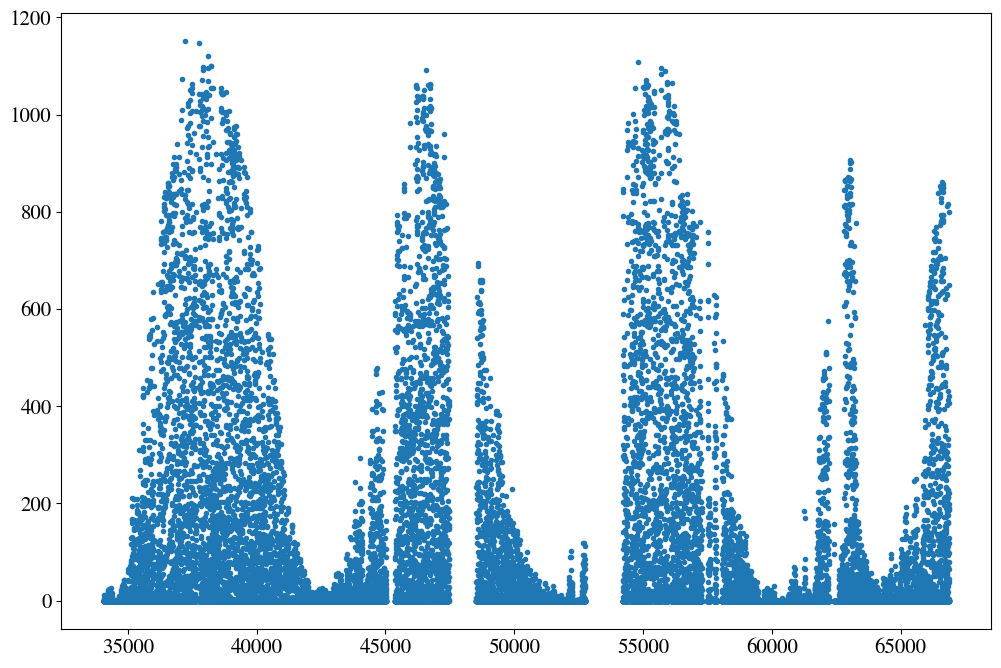

In [9]:
plt.plot(df[df["site"]==site_to_num("B")][Y_col], ".")

# Feature engineering

This part is the main feature engineering. As of right now, a new feature must be added two places. First to df, then to dataframes[location]["X_test_estimated"], in the loop below

In [10]:
month_mapping = {
    1 : 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    8: 6,
    9: 5,
    10: 4,
    11: 3,
    12: 2
}

In [11]:
def add_features(df):
    df["month"] = df["time"].dt.month
    df["day"] = df["time"].dt.day
    df["hour"] = df["time"].dt.hour
    df["date_calc"]
    df["date_calc"]= df["date_calc"].fillna(df["time"])
    df["date_difference"] = df["time"]-df["date_calc"]

    df["date_difference"] = df["date_difference"] / pd.Timedelta(hours=1)
    df["is_estimated"] = df["date_difference"].apply(lambda x : int(x > 0))

    df["normal_radiation"] = np.sin(df["sun_elevation:d"] * np.pi / 180) * df["direct_rad:W"]
    df['direct_rad_cloud_interaction'] = df['direct_rad:W'] * df['effective_cloud_cover:p']

    df['sun_elevation_month_interaction'] = df['sun_elevation:d'] * df['month'].map(month_mapping)

    df['elevation_cloud_interaction'] = df['sun_elevation:d'] * df['effective_cloud_cover:p']

    df['cos_elevation'] = np.cos(np.radians(90 - df['sun_elevation:d']))
    df['sun_elevation_squared'] = df['sun_elevation:d'] ** 2
    df['elevation_month_interaction'] = df['sun_elevation:d'] * df['month'].map(month_mapping)

    df["is_midday"] = df["hour"].apply(lambda x : int(abs(x - 12) < 2))

    sin_cos_cols = {"month": 12, "day": 30, "hour": 24}

    for col, period in sin_cos_cols.items():
        df[f"{col}_sin"] = np.sin(df[col] * 2* np.pi / period)
        df[f"{col}_cos"] = np.cos(df[col] * 2* np.pi / period)

    return df

In [12]:
df = add_features(df)
# for location in folders:
#     dataframes[location]["X_test_estimated"] = add_features(dataframes[location]["X_test_estimated"])

## Remove features

This part removes features. It can be done in a few ways

- As a column name: In order to remove a feature by column name, add the name to the list "remove_cols". 
- As a keyword: If you want to remove all features with a specific keyword, add it to the list "remove_words"

This part also generates Y_col, which is used several places as the name of the column we are trying to predict, and X_cols, the list of columns we use to predict Y_col

In [13]:
list(df.columns)

['index',
 'time',
 'pv_measurement',
 'time1',
 'time2',
 'time3',
 'absolute_humidity_2m:gm3',
 'air_density_2m:kgm3',
 'ceiling_height_agl:m',
 'clear_sky_energy_1h:J',
 'clear_sky_rad:W',
 'cloud_base_agl:m',
 'dew_or_rime:idx',
 'dew_point_2m:K',
 'diffuse_rad:W',
 'diffuse_rad_1h:J',
 'direct_rad:W',
 'direct_rad_1h:J',
 'effective_cloud_cover:p',
 'elevation:m',
 'fresh_snow_12h:cm',
 'fresh_snow_1h:cm',
 'fresh_snow_24h:cm',
 'fresh_snow_3h:cm',
 'fresh_snow_6h:cm',
 'is_day:idx',
 'is_in_shadow:idx',
 'msl_pressure:hPa',
 'precip_5min:mm',
 'precip_type_5min:idx',
 'pressure_100m:hPa',
 'pressure_50m:hPa',
 'prob_rime:p',
 'rain_water:kgm2',
 'relative_humidity_1000hPa:p',
 'sfc_pressure:hPa',
 'snow_density:kgm3',
 'snow_depth:cm',
 'snow_drift:idx',
 'snow_melt_10min:mm',
 'snow_water:kgm2',
 'sun_azimuth:d',
 'sun_elevation:d',
 'super_cooled_liquid_water:kgm2',
 't_1000hPa:K',
 'total_cloud_cover:p',
 'visibility:m',
 'wind_speed_10m:ms',
 'wind_speed_u_10m:ms',
 'wind_spe

In [14]:
not_X_cols=["time", "pv_measurement", "date_forecast", "date_calc", "index", "time1", "time2", "time3"]
df.columns
X_cols=[]

for col in df.columns:
    if col not in not_X_cols:
        X_cols.append(col)

Y_col="pv_measurement"

X_cols_new = []

remove_non_rolling = [col for col in non_rolling_cols if col != "site"]

remove_cols= [] # <--- Add columns to remove here

remove_words = [] # <-- Add keywords to remove here

# "snow", "wind", "pressure"


for col in X_cols:
    for word in remove_words:
        if word in col:
            remove_cols.append(col)

for col in X_cols:
    if not col in remove_cols:
        X_cols_new.append(col)
    

X_cols = X_cols_new




The next part is just to check the number of features, making sure its not to insane

In [15]:
X_cols.__len__()

200

# Categorical cols

Here, I generate the categorical cols, which are the columns which has a discrete number of possible values

In [16]:
categorical_cols = []
self_added_categorical = ["site", "elevation:m", "is_estimated", "is_midday"]

for index, col in enumerate(X_cols):
    if col in self_added_categorical:
        categorical_cols.append(col)
    if ":" not in col:
        continue
    # unit=col.split(":")[1]
    if "idx" in col:
        categorical_cols.append(col)

# for col_idx in categorical_cols:
#     plt.title(X_cols[col_idx])
#     plt.plot(df[X_cols[col_idx]], ".")
#     plt.show()

print(categorical_cols)

['dew_or_rime:idx', 'elevation:m', 'is_day:idx', 'is_in_shadow:idx', 'precip_type_5min:idx', 'snow_drift:idx', 'site', 'dew_or_rime:idx1', 'is_day:idx1', 'is_in_shadow:idx1', 'precip_type_5min:idx1', 'snow_drift:idx1', 'dew_or_rime:idx2', 'is_day:idx2', 'is_in_shadow:idx2', 'precip_type_5min:idx2', 'snow_drift:idx2', 'dew_or_rime:idx3', 'is_day:idx3', 'is_in_shadow:idx3', 'precip_type_5min:idx3', 'snow_drift:idx3', 'is_estimated', 'is_midday']


In [17]:
for col in categorical_cols:
    df[col]=df[col].astype(int)

# Generating X and Y

In [18]:
X = df[X_cols]
Y=df[Y_col]

# Model

# LGBM KFolds

In [77]:
n_splits = 5

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize your CatBoostRegressor
# To store the fold models




In [78]:
def clean_names(name_list):
    cleaned_list = [re.sub('[^a-zA-Z0-9]', '', name) for name in name_list]
    return cleaned_list

def clean_column_names(df):
    df.columns = df.columns.str.replace('[^a-zA-Z0-9]', '', regex=True)
    return df


categorical_cols_lgbm = clean_names(categorical_cols)

X_cols_lgbm = clean_names(X_cols)
X_lgbm = clean_column_names(X)
Y_col_lgbm = re.sub('[^a-zA-Z0-9]', '', Y_col)
Y_lgbm = Y.copy()
Y_lgbm.name = re.sub('[^a-zA-Z0-9]', '', Y_lgbm.name)

In [110]:
fold_models = []

model = LGBMRegressor(num_iterations=int(5e3))


# Perform K-Fold CV
for train_index, test_index in kf.split(X_lgbm):
    # Split data
    X_train, X_test = X_lgbm.iloc[train_index], X_lgbm.iloc[test_index]
    y_train, y_test = Y_lgbm.iloc[train_index], Y_lgbm.iloc[test_index]
    
    # Create Pool objects
    lgb_eval = [(X_test, y_test)]


    model.fit(X_train, y_train, eval_set=lgb_eval)
            #   , eval_set=lgb_eval)

    
    # Save the model for this fold
    fold_models.append(deepcopy(model))
    
    # Evaluate the model performance
    predictions = model.predict(X_test)
    fold_rmse = mean_absolute_error(predictions, y_test)
    print(f"MAE for fold: {fold_rmse}")

/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29649
[LightGBM] [Info] Number of data points in the train set: 70947, number of used features: 196
[LightGBM] [Info] Start training from score 295.576624


/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


MAE for fold: 74.46215213531991
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29659
[LightGBM] [Info] Number of data points in the train set: 70947, number of used features: 196
[LightGBM] [Info] Start training from score 297.933905


/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


MAE for fold: 72.13790799979589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29656
[LightGBM] [Info] Number of data points in the train set: 70947, number of used features: 196
[LightGBM] [Info] Start training from score 298.120276


/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


MAE for fold: 72.9213264423754
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29655
[LightGBM] [Info] Number of data points in the train set: 70947, number of used features: 196
[LightGBM] [Info] Start training from score 296.792979


/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


MAE for fold: 73.66273145718931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29640
[LightGBM] [Info] Number of data points in the train set: 70948, number of used features: 196
[LightGBM] [Info] Start training from score 293.522843
MAE for fold: 78.41446694896464


/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [111]:

def predict_fold_models(fold_models, X):

    predictions = np.zeros((X.shape[0], len(fold_models)))

    for i, model in enumerate(fold_models):
        # Predict using the ith fold model
        predictions[:, i] = model.predict(X)

    # Calculate the average prediction across all fold models
    y_array = np.mean(predictions, axis=1)
    
    y_out = np.zeros(len(y_array))

    for i, y in enumerate(y_array):
        if y < 0.05:
            y_out[i] = 0
        else: 
            y_out[i] = y
    return y_out

y_test = predict_fold_models(fold_models, X)

In [112]:
mean_absolute_error(y_test, Y)

/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


17.881938986035845

(-750.0, 750.0)

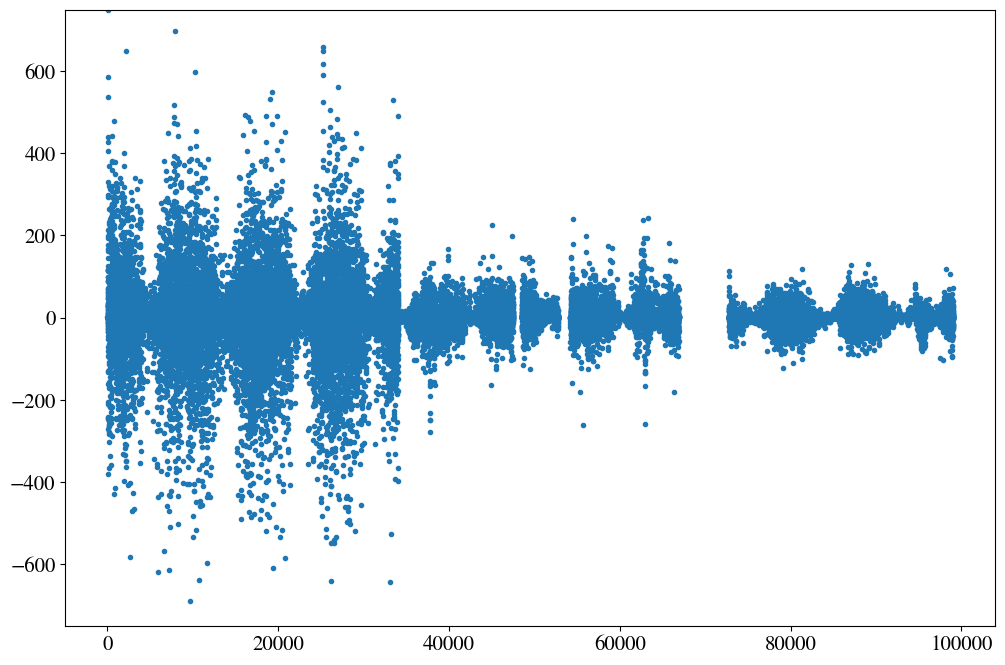

In [113]:
lim=0.75e3
plt.plot((y_test - Y), ".")
plt.ylim((-lim, lim))

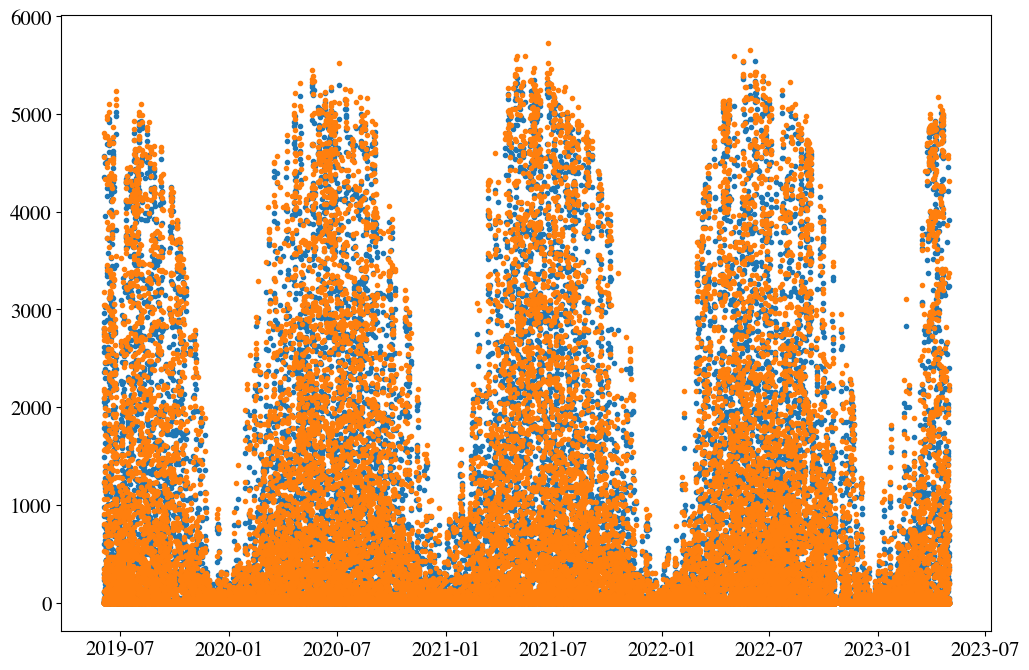

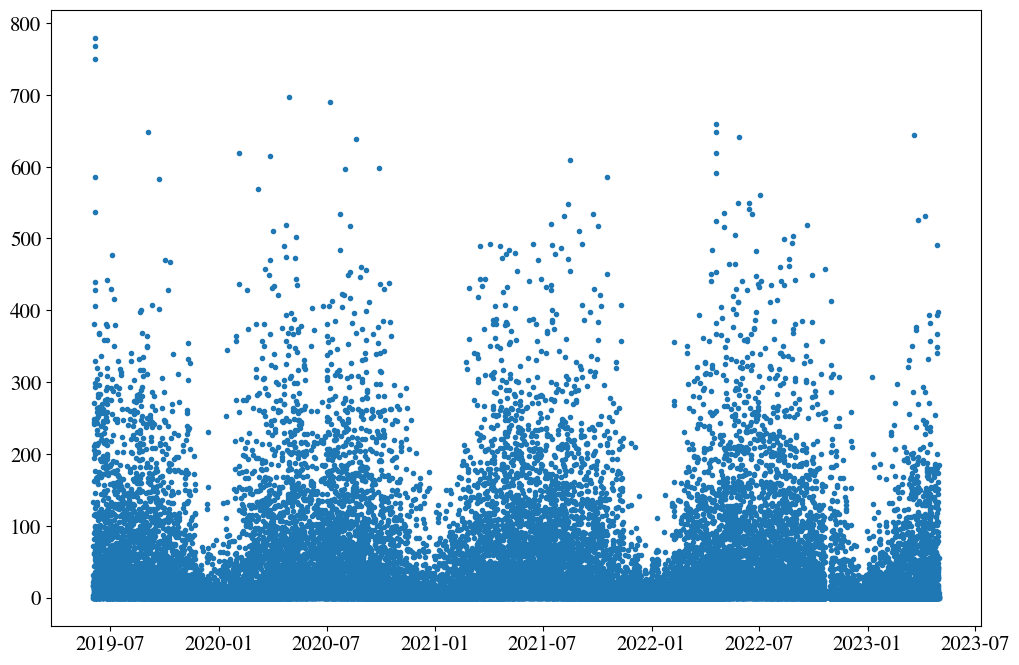

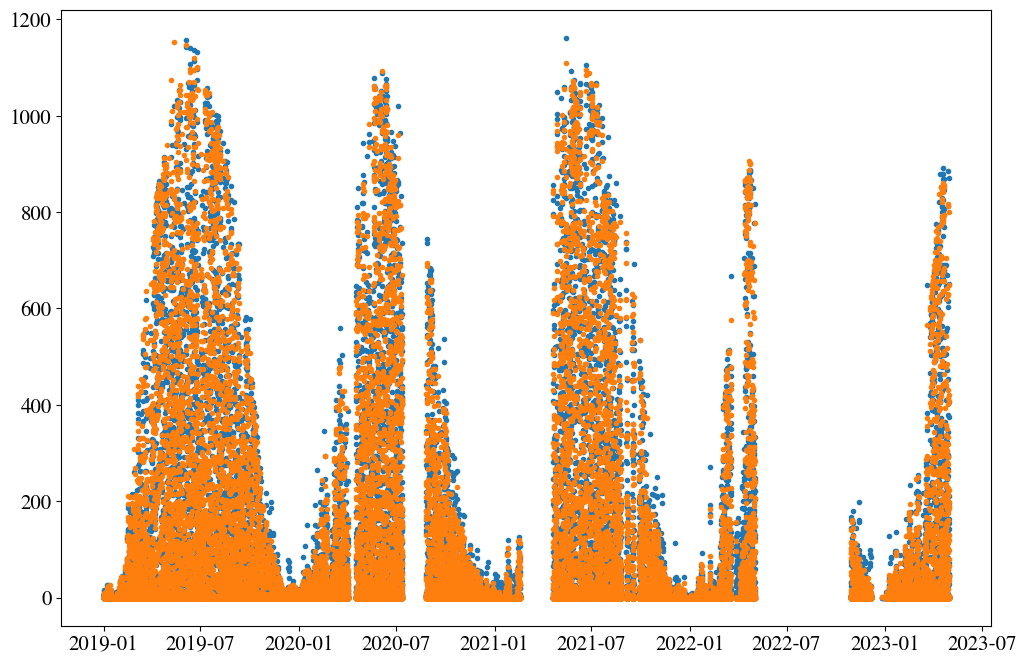

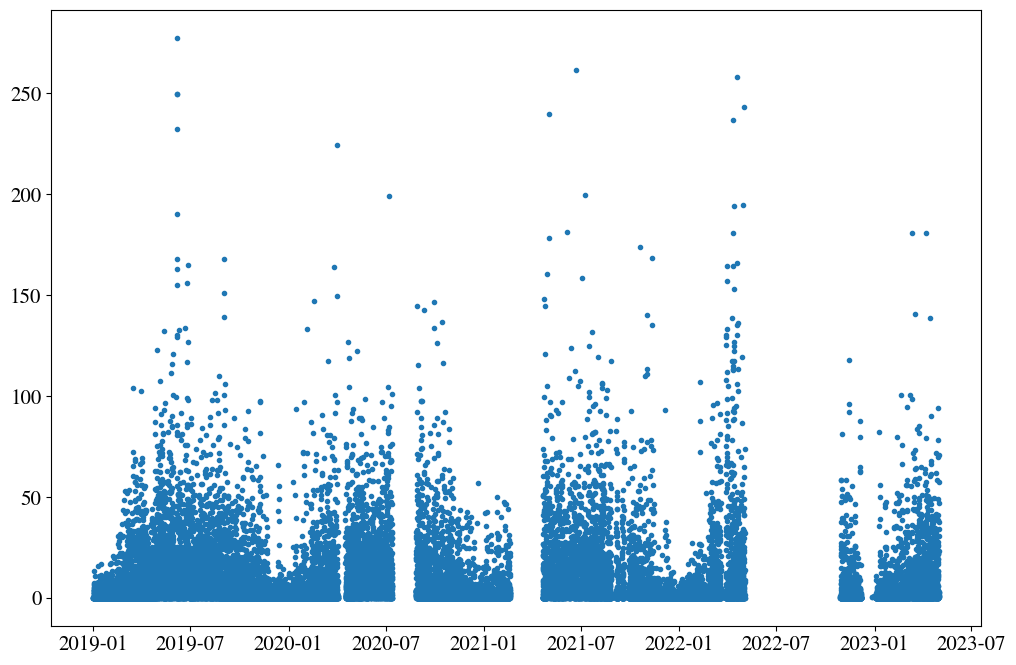

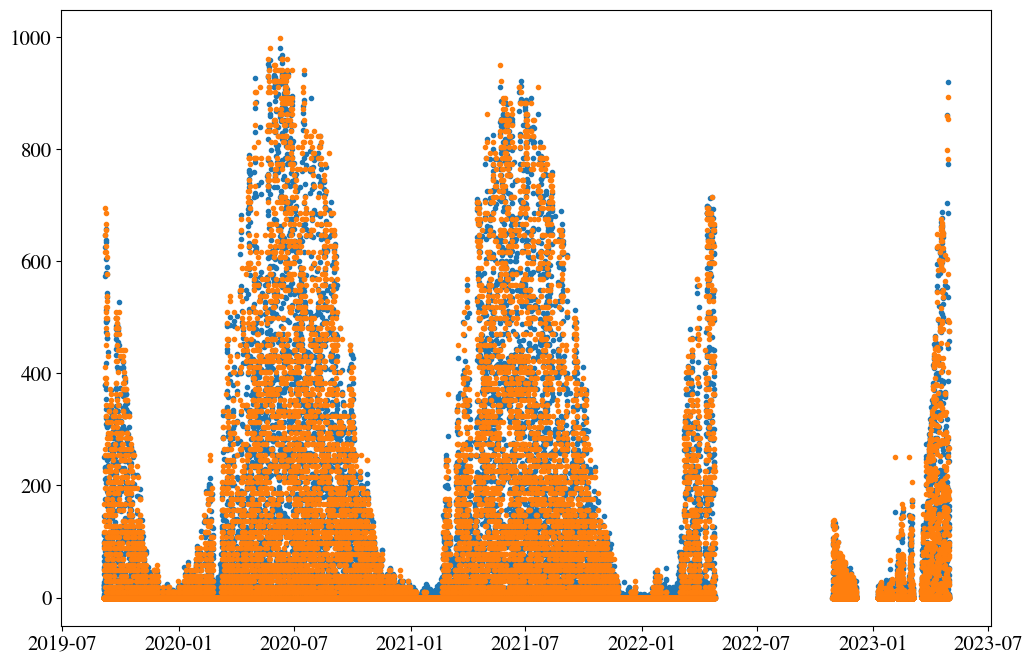

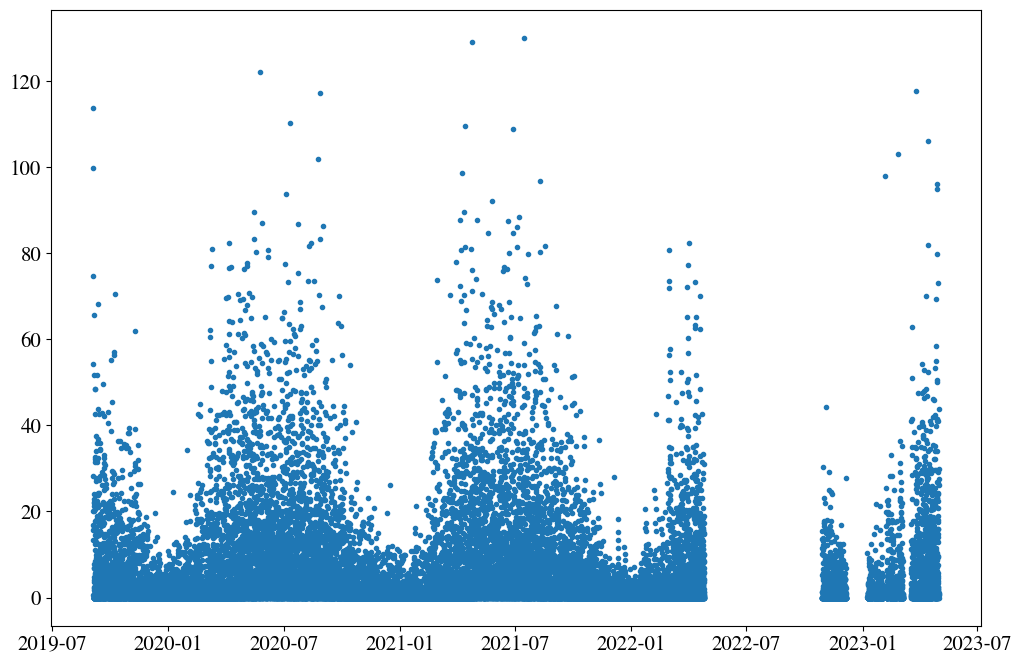

In [114]:
for site in range(1, 4):
    df_here=df
    df_site=df[df["site"]==site]
    y_here = predict_fold_models(fold_models, df_site[X_cols])
    plt.plot(df_site["time"], y_here, ".")
    plt.plot(df_site["time"], df_site[Y_col], ".")
    plt.show()

    plt.plot(df_site["time"], abs(df_site[Y_col] - y_here), ".")
    plt.show()


# Test on test_thing

In [115]:
os.listdir("../data/")
path_test="../data/test.csv"
df_final = pd.read_csv(path_test)
df_final["time"] = pd.to_datetime(df_final["time"])

df_final

id                time  prediction location
0        0 2023-05-01 00:00:00           0        A
1        1 2023-05-01 01:00:00           0        A
2        2 2023-05-01 02:00:00           0        A
3        3 2023-05-01 03:00:00           0        A
4        4 2023-05-01 04:00:00           0        A
...    ...                 ...         ...      ...
2155  2155 2023-07-03 19:00:00           0        C
2156  2156 2023-07-03 20:00:00           0        C
2157  2157 2023-07-03 21:00:00           0        C
2158  2158 2023-07-03 22:00:00           0        C
2159  2159 2023-07-03 23:00:00           0        C

[2160 rows x 4 columns]

In [116]:
def pred_location(df_final, location, model, auto_ml=False, seperate_model=False, kfolds_model=False):
    # df_final_location = df_final[df_final["location"]==location]
    # df_final_location["time"] = pd.to_datetime(df_final_location["time"])
    
    # df_final_location_merged = pd.merge(left=df_final_location, right=dataframes[location]["X_test_estimated"], left_on="time", right_on="date_forecast")
    # df_final_location_merged["site"] = df_final_location_merged["location"].apply(site_to_num)

    # for col in categorical_cols:
    #     df_final_location_merged[col]=df_final_location_merged[col].astype(int)

    # if auto_ml:
    #     h2o_predict_frame = h2o.H2OFrame(df_final_location_merged[X_cols])

    #     for col in categorical_cols:
    #         h2o_predict_frame[col] = h2o_predict_frame[col].asfactor()


    #     preds = model.predict(h2o_predict_frame)
    #     preds=preds.as_data_frame()

        
    
    # elif seperate_model:
    #     preds = model.predict(df_final_location_merged[X_cols], site_to_num(location))
    
    # else:
    #     preds = model.predict(df_final_location_merged[X_cols])
    column = "X_test_estimated"
    df_Y = df_final[df_final["location"]==location]
    df_Y = df_Y[df_Y["time"].isin(dataframes[location][column]["date_forecast"])].reset_index()

    df_to_predict = feature(df_Y, dataframes[location][column])
    df_to_predict["site"] = df_to_predict["location"].apply(site_to_num)
    

    df_to_predict = add_features(df_to_predict)
    
    for col in categorical_cols:
        df_to_predict[col]=df_to_predict[col].astype(int)
    

    if kfolds_model:
        preds = predict_fold_models(model, df_to_predict[X_cols])

    else:
        preds = model.predict(df_to_predict[X_cols])


    return preds, df_to_predict



The only thing you need to consider in this section is the model. If you have used auto_ml or the seperated models you must also switch those variables.

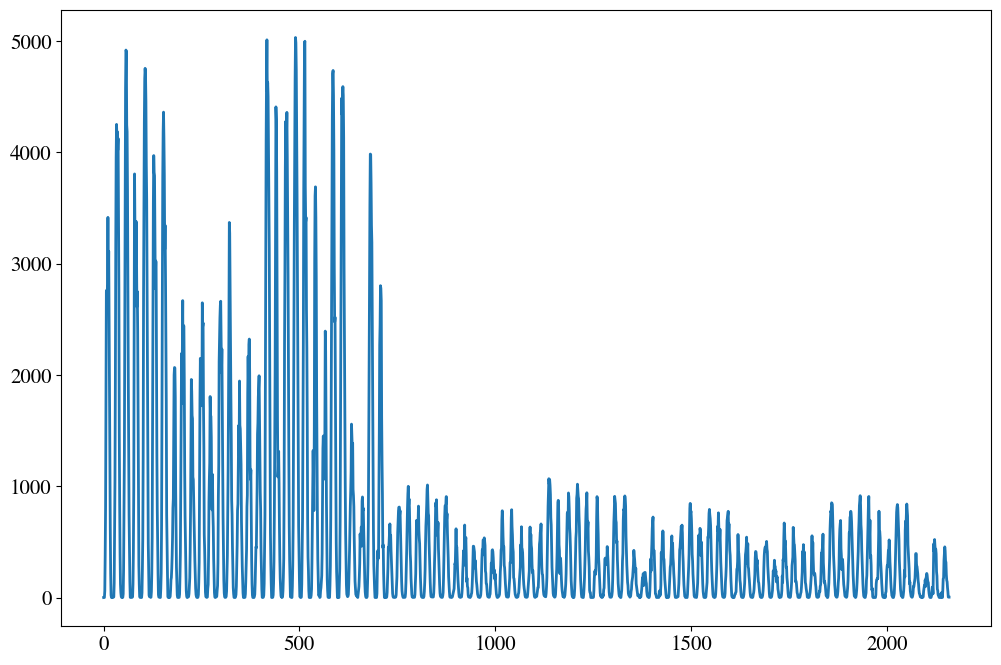

In [117]:
model=fold_models          # <--- Only replace this with your model. Defined in another section
auto_ml=False
seperate_model_param=False
kfolds_model=True

preds_A, df_A = pred_location(df_final, "A", model, auto_ml=auto_ml, seperate_model=seperate_model_param, kfolds_model=kfolds_model)
preds_B, df_B = pred_location(df_final, "B", model, auto_ml=auto_ml, seperate_model=seperate_model_param, kfolds_model=kfolds_model)
preds_C, df_C = pred_location(df_final, "C", model, auto_ml=auto_ml, seperate_model=seperate_model_param, kfolds_model=kfolds_model)


df_A["prediction"] = preds_A
df_B["prediction"] = preds_B
df_C["prediction"] = preds_C

df_final_final = pd.concat([df_A, df_B, df_C], ignore_index=True)

plt.plot(df_final_final["id"], df_final_final["prediction"])

In [118]:
df_final_final.set_index("id")

file_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

df_final_final[["id", "prediction"]].to_csv(f"../predictions/{file_name}.csv", index=False)
# df_final_final

In [119]:
best_submission=pd.read_csv("../predictions/best_submission03.csv")
current_submission = df_final_final[["id", "prediction"]]

In [120]:
mean_absolute_error(current_submission["prediction"], best_submission["prediction"])

/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/sindre/.cache/pypoetry/virtualenvs/tdt4173-Lc7W1XJb-py3.10/lib/python3.10/site-packages/sklearn/util

59.94218432994995

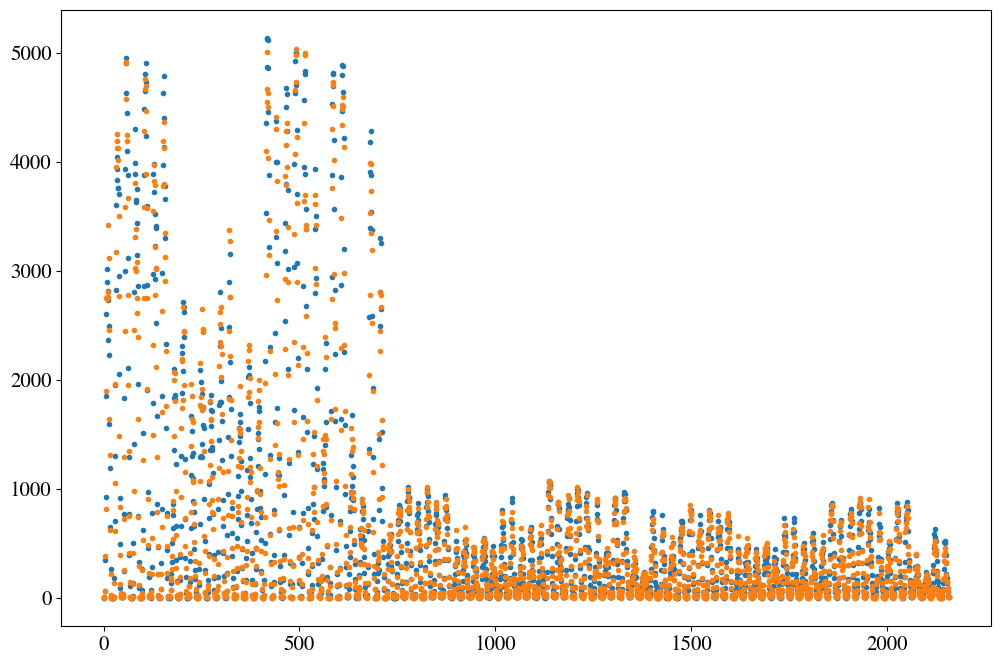

In [121]:
plt.plot(best_submission["prediction"], ".")
plt.plot(current_submission["prediction"], ".")

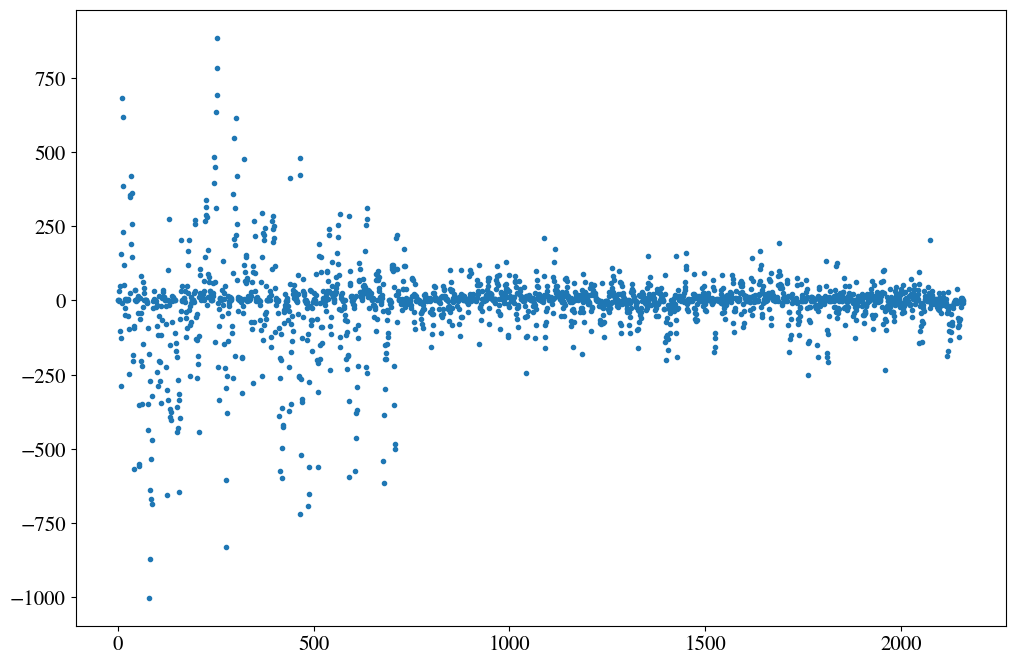

In [91]:
plt.plot(current_submission["prediction"] - best_submission["prediction"], ".")

In [92]:
path=f"../predictions/{file_name}.csv"
message="Basic LGBM model, 10k iterations"

In [93]:
!kaggle competitions submit -c solar-energy-production-forecasting -f {path} -m "{message}"

100%|██████████████████████████████████████| 46.3k/46.3k [00:00<00:00, 57.5kB/s]
Successfully submitted to Solar Energy Production Forecasting